In [1]:
from explore_import import  *
import ionbot_preprocess as io
import data_preprocess as dt
import tpp_preprocess as tpp
import hpp_checker as hpp
import pyteomics.auxiliary as aux

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
project_palette={"canon":"orangered","trembl":"yellowgreen","openprot":"cornflowerblue",
                "Canon_unique":"salmon", "NonCanon_unique":"skyblue", "Shared":"darkkhaki",
                "Canon":"firebrick","Noncanon":"steelblue"}

In [3]:
peptide_classes={"NonCanon_unique":["unique_to_Noncanon",'shared_in_Noncanon'],
                "Canon_unique":["unique_to_Canon",'shared_in_Canon'],
                "Shared":['shared_btw_can_noncan']}

In [4]:
working_folder = "./../msfragger_pride_reanalysis/fragpipe23_ms42/"
work_subdirs_db=["canon","trembl","openprot"]
work_subdirs_dts=["PXD002057","PXD005833","PXD014258"]
figsave_folder="./oui_discovery_subfigures/explore-1-msfragger/"
wildcard="msfr"

In [5]:
dt.list_files(working_folder)

/
trembl/
    PXD014258/
        ESC_HF_SampleHela/
            psm.tsv
            peptide.tsv
            filelist_proteinprophet.txt
            filter.log
            interact.mod.pep.xml
            fragger.params
            log_2025-05-27_11-36-28.txt
            shepherd.config
            fragpipe.workflow
            ion.tsv
            combined.prot.xml
            sdrf.tsv
            interact.pep.xml
            fragpipe-files.fp-manifest
            ptm-shepherd-output/
                global.profile.tsv
                global.modsummary.tsv
        ESC_HF_Sample_BT474/
            interact.pep.xml
            log_2025-05-27_10-17-10.txt
            ion.tsv
            peptide.tsv
            filelist_proteinprophet.txt
            sdrf.tsv
            fragger.params
            psm.tsv
            combined.prot.xml
            interact.mod.pep.xml
            shepherd.config
            fragpipe.workflow
            filter.log
            fragpipe-files.fp-manifest
     

In [6]:
mgfspectraN_datasets=pickle.load(open('./../mgfspectraN_datasets.pickle', 'rb'))

In [7]:
def find_files(root_dir, target_filename_prefix):
    result_files = []
    for dirpath, _, filenames in os.walk(root_dir):
        #print(filenames)
        if any(target_filename_prefix in x for x in filenames):
            #print(filenames)
            target_filenames=[x for x in filenames if target_filename_prefix in x]
            for target_filename in target_filenames:
                file=os.path.join(dirpath, target_filename)
                file=file.replace("\\", "/")
                result_files.append(file)
    return result_files
def load_philosopher_output(root_dir,target_filename_prefix="mod.pep.xml"):
    files=find_files(root_dir,target_filename_prefix)
    print(files)
    dfs=[]
    for file in files:    
        if "pep" in target_filename_prefix:
            with pepxml.read(file) as reader:
                data = list(reader)
        if "prot" in target_filename_prefix:
            with protxml.read(file) as reader:
                data = list(reader)
        df = pd.DataFrame(data)
        df["spectrum_file"]=file.split("/")[-2]#.replace("interact-","").replace(target_filename_prefix,"")
        df["dataset"]=file.split("/")[-3]
        df["database"]=file.split("/")[-4]
        dfs.append(df)
    files_df=pd.concat(dfs)
    return files_df
def get_hitclass(row):
    #print(row)
    proteins=[hit if 'protein_descr' in hit.keys() else {'protein_descr':hit['protein']} for hit in row[0]['proteins']]
    proteins=[hit if len(hit['protein_descr'])>1 else {'protein_descr':hit['protein']} for hit in proteins]
    vals=[ "D" if "decoy" in hit['protein_descr'] else "NC" if "no_match" in hit['protein_descr'] or (("II_" in hit['protein_descr'] or "IP_" in hit['protein_descr']) and "protein" not in hit.keys()) else "CONTAM" if "CONTAM" in hit['protein_descr'] or "contam" in hit['protein_descr'] else "T"  for hit in proteins ]
    #print(proteins)
    #print(vals)
    if any("D"==x for x in vals):
        return "D"
    if any("CONTAM"==x or "contam"==x for x in vals):
        return "CONTAM"
    if all("NC"==x for x in vals):
        return "NC"
    else:
        return "T"
    
def get_proteins(row):
    return "||".join([hit['protein'] for hit in row[0]['proteins']])

def get_pepclass(row):
    #print(row) #here was a mistake with D
    if row["hit_class"]=="D":
        pepclass="Decoy"
    if row["hit_class"]=="CONTAM":
        pepclass="Contam"
    elif row["hit_class"]=="NC":
        pepclass="shared_in_Noncanon" if "||" in row["proteins"] else "unique_to_Noncanon"
    else:
        proteins=[hit if 'protein_descr' in hit.keys() else {'protein_descr':hit['protein']} for hit in row["search_hit"][0]['proteins']]
        proteins=[hit if len(hit['protein_descr'])>1 else {'protein_descr':hit['protein']} for hit in proteins]
        vals=["NC" if "no_match" in hit['protein_descr'] or ("II_" in hit['protein_descr'] or "IP_" in hit['protein_descr']) else "C"  for hit in proteins]
        pepclass="shared_in_Canon" if all("C"==v for v in vals) and len(vals)>1 else "unique_to_Canon" if all("C"==v for v in vals) and len(vals)==1 else "shared_btw_can_noncan"
    return pepclass

def parse_search_hit(row,feature):
    row=row[0]
    if not isinstance(feature,list):
        if feature in row.keys():
            return row[feature]
    if isinstance(feature,list):
        item=row
        for i in range(len(feature)):
            if isinstance(item,list) and i!=len(feature)-1:
                try: 
                    item=item[1]; 
                except:
                    item=item[0];
            #print(item)
            item=item[feature[i]] if feature[i] in item.keys() else None
            if item==None:
                return None
    return item    
def init_file(df):
    df["proteins"]=df.search_hit.apply(get_proteins)
    df["hit_class"]=df.search_hit.apply(get_hitclass)
    df["peptide_class"]=df.apply(get_pepclass,axis=1)
    ask_features=["peptide","num_missed_cleavages",'num_tot_proteins',['search_score','expect'],
                  ["analysis_result","peptideprophet_result","parameter","fval"],['analysis_result','peptideprophet_result','probability'],
             ['ptm_result','localization'],['ptm_result','ptm_mass'],['ptm_result','localization_peptide'],
                  'modified_peptide','modifications','massdiff','calc_neutral_pep_mass']
    for feature in ask_features:
        col=":".join(feature) if isinstance(feature,list) else feature
        df[col]=df.search_hit.apply(lambda x: parse_search_hit(x,feature))
    return df
def get_qval(df,score="analysis_result:peptideprophet_result:parameter:fval"):
    """ calculate FDR and q-values based on score"""
    df = df.sort_values(by=score, ascending=False).reset_index(drop=True)        
    # Calculate cumulative counts of targets and decoys
    df['cum_targets'] = (df['hit_class'] != 'D').cumsum()
    df['cum_decoys'] = (df['hit_class'] == 'D').cumsum()
    # Calculate FDR
    df['FDR'] = df['cum_decoys'] / df['cum_targets']
    # cumulative minimum from bottom to top
    df['q-value'] = df['FDR'][::-1].cummin()[::-1]  
    df["q-value"].fillna(0,inplace=True)
    return df
def get_qval_prot(df,score="confidence"):
    """ calculate FDR and q-values based on score"""
    df = df.sort_values(by=score, ascending=False).reset_index(drop=True)        
    # Calculate cumulative counts of targets and decoys
    df['cum_targets'] = (df['protein_class'] != 'Decoy').cumsum()
    df['cum_decoys'] = (df['protein_class'] == 'Decoy').cumsum()
    # Calculate FDR
    df['FDR'] = df['cum_decoys'] / df['cum_targets']
    # cumulative minimum from bottom to top
    df['q-value'] = df['FDR'][::-1].cummin()[::-1]  
    df["q-value"].fillna(0,inplace=True)
    return df

In [8]:
def classify_leadprot(x):
    x=x.replace("decoy_","")
    if 'CONTAMINANT' in x.upper():
        return 'Contam'
    elif x.startswith('II_') or x.startswith('IP_'):
        return 'NonCanon'
        # Ensembl is canonical
    else:
        return 'Canon'

def is_peptide_canonical(x):
    '''x is the list of protein classes'''
    if np.array([_=='Contam' for _ in x]).any():
        return 'Contam'
    if np.array([_=='Canon' for _ in x]).any():
        return 'Canonical'
    return 'NonCanonical'

def classifiy_mods(row):
    if pd.isna(row["modifications:type_re"]):
        return 'Unmodified'
    elif row["modifications:type_re"]=="unexpected":
        return 'Unexpected'
    else:
        return 'Expected'

def custom_subgroup_filter(data_):
    filtered_subgroups = []
    for (c,m),df in data_.groupby(['isCanonical','isModified']).__iter__():
        tmp = aux.target_decoy.qvalues(df, key='analysis_result:peptideprophet_result:parameter:fval', reverse=True, is_decoy=df.hit_class=='D',
                                      formula=1, full_output=True, q_label='custom_q')
        filtered_subgroups.append(tmp)

    return pd.concat(filtered_subgroups, ignore_index=True)

### Load PeptideProphet

In [9]:
#pepxml after PTMProphet

prophet_combined_datasets={}
for work_subdir in work_subdirs_dts:
    data_frames = {}
    for database in work_subdirs_db:
        path=os.path.join(working_folder,database,work_subdir)
        print(path)
        data_frames[database]=load_philosopher_output(path)
        print(data_frames[database].shape)
    prophet_combined_datasets[work_subdir] = data_frames

./../msfragger_pride_reanalysis/fragpipe23_ms42/canon/PXD002057
['./../msfragger_pride_reanalysis/fragpipe23_ms42/canon/PXD002057/130327_o2_06_hu_P3_2hr/interact-130327_o2_06_hu_P3_2hr.mod.pep.xml', './../msfragger_pride_reanalysis/fragpipe23_ms42/canon/PXD002057/130327_o2_04_hu_P2_2hr/interact-130327_o2_04_hu_P2_2hr.mod.pep.xml', './../msfragger_pride_reanalysis/fragpipe23_ms42/canon/PXD002057/130327_o2_01_hu_C1_2hr/interact-130327_o2_01_hu_C1_2hr.mod.pep.xml', './../msfragger_pride_reanalysis/fragpipe23_ms42/canon/PXD002057/130327_o2_02_hu_P1_2hr/interact-130327_o2_02_hu_P1_2hr.mod.pep.xml', './../msfragger_pride_reanalysis/fragpipe23_ms42/canon/PXD002057/130327_o2_03_hu_C2_2hr/interact-130327_o2_03_hu_C2_2hr.mod.pep.xml', './../msfragger_pride_reanalysis/fragpipe23_ms42/canon/PXD002057/130327_o2_05_hu_C3_2hr/interact-130327_o2_05_hu_C3_2hr.mod.pep.xml']
(50423, 13)
./../msfragger_pride_reanalysis/fragpipe23_ms42/trembl/PXD002057
['./../msfragger_pride_reanalysis/fragpipe23_ms42/trem

### Extract features and get global FDR

In [10]:
#add decoy/target columns, calculate q-value based on fval

for dataset, subdict in prophet_combined_datasets.items():
    for database,df_ds in subdict.items():
        #extract features
        df_ds=init_file(df_ds)
        df_ds_new=[]
        for spectrum_file in set(df_ds.spectrum_file):
            print(dataset,database,spectrum_file)
            df=df_ds.loc[df_ds.spectrum_file==spectrum_file]
            #df=get_qval(df)
            df = aux.target_decoy.qvalues(df,
                                            key='analysis_result:peptideprophet_result:parameter:fval',
                                            reverse=True,
                                            is_decoy=(df.hit_class == 'D'),
                                            q_label='global_q',
                                            formula=1,
                                            full_output=True)
            df_ds_new.append(df)
        prophet_combined_datasets[dataset][database]=pd.concat(df_ds_new)

PXD002057 canon 130327_o2_05_hu_C3_2hr
PXD002057 canon 130327_o2_02_hu_P1_2hr
PXD002057 canon 130327_o2_03_hu_C2_2hr
PXD002057 canon 130327_o2_01_hu_C1_2hr
PXD002057 canon 130327_o2_06_hu_P3_2hr
PXD002057 canon 130327_o2_04_hu_P2_2hr
PXD002057 trembl 130327_o2_05_hu_C3_2hr
PXD002057 trembl 130327_o2_02_hu_P1_2hr
PXD002057 trembl 130327_o2_03_hu_C2_2hr
PXD002057 trembl 130327_o2_01_hu_C1_2hr
PXD002057 trembl 130327_o2_06_hu_P3_2hr
PXD002057 trembl 130327_o2_04_hu_P2_2hr
PXD002057 openprot 130327_o2_05_hu_C3_2hr
PXD002057 openprot 130327_o2_02_hu_P1_2hr
PXD002057 openprot 130327_o2_03_hu_C2_2hr
PXD002057 openprot 130327_o2_01_hu_C1_2hr
PXD002057 openprot 130327_o2_06_hu_P3_2hr
PXD002057 openprot 130327_o2_04_hu_P2_2hr
PXD005833 canon AM13
PXD005833 canon AM21
PXD005833 canon AM8
PXD005833 canon AM18
PXD005833 canon AM15
PXD005833 canon AM20
PXD005833 canon AM10
PXD005833 canon AM7
PXD005833 canon AM16
PXD005833 canon AM14
PXD005833 canon AM9
PXD005833 canon AM19
PXD005833 canon AM17
PXD0

### Add modifications

In [11]:
def load_ptmshepherd_output(root_dir,filename="global.profile.tsv"):   
    files=find_files(root_dir,filename)
    print(files)
    dfs=[]
    for file in files:
        df=pd.read_csv(file,sep="\t")
        #fix file, run once
        df.reset_index(inplace=True)
        df.columns=df.columns.tolist()[1:]+["drop"]
        df.drop("drop",axis=1,inplace=True)
        df["spectrum_file"]=file.split("/")[-2]#.replace("interact-","").replace(target_filename_prefix,"")
        df["dataset"]=file.split("/")[-3]
        df["searchDB"]=file.split("/")[-4]
        dfs.append(df)
    files_df=pd.concat(dfs)
    return files_df
def annotate_massshift(value,ptm_df,col):
    #print(value)
    a=ptm_df[(ptm_df['peak_lower'] <= value) & (ptm_df['peak_upper'] >= value)]
    if len(a[col])==0: 
        return None
    return "||".join(set([str(x).split("shift ")[-1] if "Unidentified" in str(x) or "Unannotated" in str(x) else str(x) for x in a[col].values.tolist()]))

def extract_trivial_aa(x):
    if not x["trivial_localization"]:
        return None
    peptide = x["ptm_result:localization_peptide"]
    filtered = [i for i in peptide if i.lower() == i]
    return filtered[0].upper()

In [12]:
#profile after PTMShepherd

data_ptm=load_ptmshepherd_output(working_folder)

['./../msfragger_pride_reanalysis/fragpipe23_ms42/trembl/PXD014258/ESC_HF_SampleHela/ptm-shepherd-output/global.profile.tsv', './../msfragger_pride_reanalysis/fragpipe23_ms42/trembl/PXD014258/ESC_HF_Sample_BT474/ptm-shepherd-output/global.profile.tsv', './../msfragger_pride_reanalysis/fragpipe23_ms42/trembl/PXD014258/ESC_HF_Sample_MCF/ptm-shepherd-output/global.profile.tsv', './../msfragger_pride_reanalysis/fragpipe23_ms42/trembl/PXD002057/130327_o2_02_hu_P1_2hr/ptm-shepherd-output/global.profile.tsv', './../msfragger_pride_reanalysis/fragpipe23_ms42/trembl/PXD002057/130327_o2_03_hu_C2_2hr/ptm-shepherd-output/global.profile.tsv', './../msfragger_pride_reanalysis/fragpipe23_ms42/trembl/PXD002057/130327_o2_05_hu_C3_2hr/ptm-shepherd-output/global.profile.tsv', './../msfragger_pride_reanalysis/fragpipe23_ms42/trembl/PXD002057/130327_o2_06_hu_P3_2hr/ptm-shepherd-output/global.profile.tsv', './../msfragger_pride_reanalysis/fragpipe23_ms42/trembl/PXD002057/130327_o2_04_hu_P2_2hr/ptm-shepherd-

In [13]:
expected_mods={57.0215,15.9949, 42.0106}
expected_mods_name=['Iodoacetamide derivative/Addition of Glycine/Addition of G','Oxidation or Hydroxylation','Acetylation']

In [14]:
for dataset, subdict in prophet_combined_datasets.items():
    for database,data in subdict.items():
        # fixed and variable PTM annotation
        data['ptm_result:ptm_mass']=data['ptm_result:ptm_mass'].astype(float)
        #mass shift annotation
        data["mapped_mass_1"]=np.nan
        data["mapped_mass_2"]=np.nan
        data["mapped_mass_1"]=data["ptm_result:ptm_mass"].apply(lambda x: annotate_massshift(float(x) if isinstance(x,str) else x,data_ptm,"mapped_mass_1"))
        data["mapped_mass_2"]=data["ptm_result:ptm_mass"].apply(lambda x: annotate_massshift(float(x) if isinstance(x,str) else x,data_ptm,"mapped_mass_2"))
        data["n_apex"]=data["mapped_mass_1"].apply(lambda x: len(x.split("||")) if isinstance(x,str) else 0)
        #reannotate variable modifications based on mapped_mass_1
        data["modifications:type_re"]=data.apply(lambda x: np.nan if not isinstance(x["mapped_mass_1"],str) 
                                                                   else "variable" if any([mod in x["mapped_mass_1"] for mod in expected_mods_name])
                                                                   else "unexpected" ,axis=1)
        prophet_combined_datasets[dataset][database]=data

### Custom and hybrid FDR

In [15]:
for dataset, subdict in prophet_combined_datasets.items():
    for database,df_ds in subdict.items():
        #extract features
        df_ds=init_file(df_ds)
        df_ds_new=[]
        for spectrum_file in set(df_ds.spectrum_file):
            print(dataset,database,spectrum_file)
            data=df_ds.loc[df_ds.spectrum_file==spectrum_file]

            data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
            
            data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
            data['isModified']  = data.apply(classifiy_mods,axis=1)
        
            # Adds a columns telling you if a PSM passes the custom filters or not (custom_filter_pass)
            data2 = custom_subgroup_filter(data)
            del data
        
            # prepare for Group-walk
            data2['isTarget'] = data2.database.apply(lambda x: int(x=='T'))
            data2['FDRGroup'] = data2.isCanonical + '_' + data2.isModified
            #hybrid
            data2["glob_cust_hybrid"]=data2.apply(lambda x: x.custom_q if x.isCanonical=="NonCanonical" else x.global_q, axis=1)
            
            df_ds_new.append(data2)
        prophet_combined_datasets[dataset][database]=pd.concat(df_ds_new)

PXD002057 canon 130327_o2_05_hu_C3_2hr
PXD002057 canon 130327_o2_02_hu_P1_2hr


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD002057 canon 130327_o2_03_hu_C2_2hr
PXD002057 canon 130327_o2_01_hu_C1_2hr


/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isModified']  = data.apply(classifiy_mods,axis=1)
/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

PXD002057 canon 130327_o2_06_hu_P3_2hr


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD002057 canon 130327_o2_04_hu_P2_2hr


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD002057 trembl 130327_o2_05_hu_C3_2hr
PXD002057 trembl 130327_o2_02_hu_P1_2hr


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD002057 trembl 130327_o2_03_hu_C2_2hr
PXD002057 trembl 130327_o2_01_hu_C1_2hr


/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isModified']  = data.apply(classifiy_mods,axis=1)
/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

PXD002057 trembl 130327_o2_06_hu_P3_2hr


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD002057 trembl 130327_o2_04_hu_P2_2hr


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD002057 openprot 130327_o2_05_hu_C3_2hr
PXD002057 openprot 130327_o2_02_hu_P1_2hr


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD002057 openprot 130327_o2_03_hu_C2_2hr
PXD002057 openprot 130327_o2_01_hu_C1_2hr


/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isModified']  = data.apply(classifiy_mods,axis=1)
/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

PXD002057 openprot 130327_o2_06_hu_P3_2hr


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD002057 openprot 130327_o2_04_hu_P2_2hr


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 canon AM13


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 canon AM21


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 canon AM8


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 canon AM18


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 canon AM15


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 canon AM20


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 canon AM10


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 canon AM7


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 canon AM16


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 canon AM14


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 canon AM9


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 canon AM19


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 canon AM17


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 canon AM11


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 canon AM12


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 trembl AM13


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 trembl AM21


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 trembl AM8


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 trembl AM18


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 trembl AM15


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 trembl AM20


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 trembl AM10


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 trembl AM7
PXD005833 trembl AM16


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 trembl AM14


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 trembl AM9


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 trembl AM19


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 trembl AM17


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 trembl AM11


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 trembl AM12


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 openprot AM13


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 openprot AM21


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 openprot AM8


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 openprot AM18


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 openprot AM15


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 openprot AM20


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 openprot AM10


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 openprot AM7


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 openprot AM16


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 openprot AM14


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 openprot AM9


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 openprot AM19


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 openprot AM17


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 openprot AM11


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD005833 openprot AM12


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD014258 canon ESC_HF_Sample_BT474


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD014258 canon ESC_HF_Sample_MCF


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD014258 canon ESC_HF_SampleHela


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD014258 trembl ESC_HF_Sample_BT474


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD014258 trembl ESC_HF_Sample_MCF


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD014258 trembl ESC_HF_SampleHela


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD014258 openprot ESC_HF_Sample_BT474


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD014258 openprot ESC_HF_Sample_MCF


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

PXD014258 openprot ESC_HF_SampleHela


/tmp/ipykernel_533673/110123016.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['protein_classes'] = data.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x.split("||")]))
/tmp/ipykernel_533673/110123016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
/tmp/ipykernel_533673/110123016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [16]:
pickle.dump(prophet_combined_datasets,open("prophet_combined_datasets.pkl","wb"))

In [ ]:
prophet_combined_datasets=pickle.load(open("prophet_combined_datasets.pkl","rb"))

#### Compare global and custom output

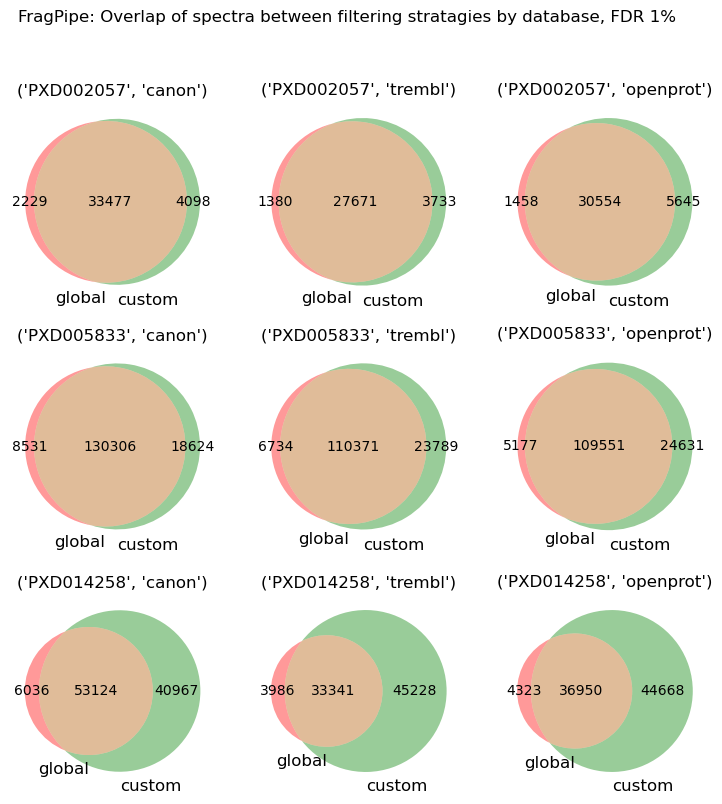

In [17]:
fig, axes = plt.subplots(3,3, figsize=(9, 9))
fig.suptitle("FragPipe: Overlap of spectra between filtering stratagies by database, FDR 1%")

for i,(dataset, subdict) in enumerate(prophet_combined_datasets.items()):
    for j,(database,data) in enumerate(subdict.items()):
        glob=data[data['global_q']<0.01].spectrum
        cust=data[data['custom_q']<0.01].spectrum
        venn2((set(glob), set(cust)), set_labels=('global', 'custom'), ax=axes[i,j])
        axes[i,j].set_title((dataset,database))

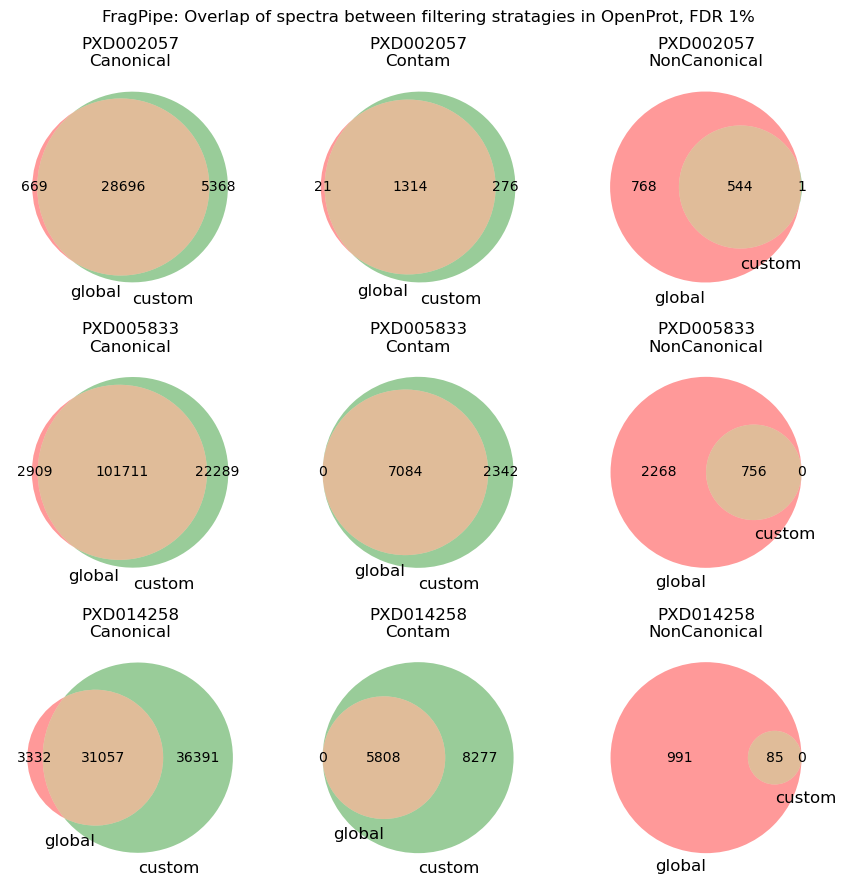

In [18]:
fig, axes = plt.subplots(3,3, figsize=(9, 9))
fig.suptitle("FragPipe: Overlap of spectra between filtering stratagies in OpenProt, FDR 1%")

for i,(dataset, subdict) in enumerate(prophet_combined_datasets.items()):
    data=subdict["openprot"]
    for j,(isCanonical,group) in enumerate(data.groupby("isCanonical")):
        glob=group[group['global_q']<0.01].spectrum
        cust=group[group['custom_q']<0.01].spectrum
        venn2((set(glob), set(cust)), set_labels=('global', 'custom'), ax=axes[i,j])
        axes[i,j].set_title(f"{dataset}\n{isCanonical}")
plt.tight_layout()

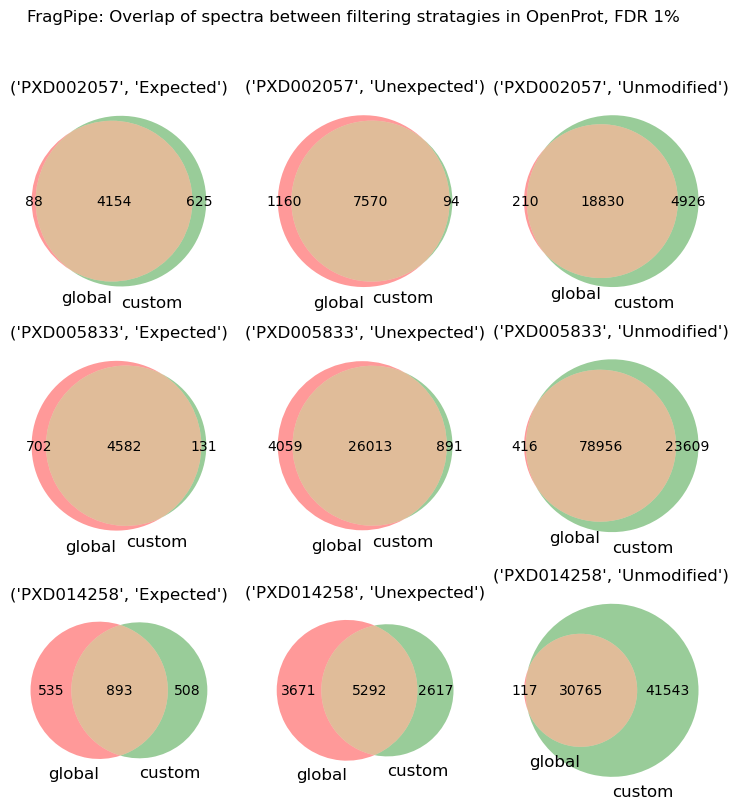

In [20]:
fig, axes = plt.subplots(3,3, figsize=(9, 9))
fig.suptitle("FragPipe: Overlap of spectra between filtering stratagies in OpenProt, FDR 1%")

for i,(dataset, subdict) in enumerate(prophet_combined_datasets.items()):
    data=subdict["openprot"]
    for j,(isModified,group) in enumerate(data.groupby("isModified")):
        glob=group[group['global_q']<0.01].spectrum
        cust=group[group['custom_q']<0.01].spectrum
        venn2((set(glob), set(cust)), set_labels=('global', 'custom'), ax=axes[i,j])
        axes[i,j].set_title((dataset,isModified))

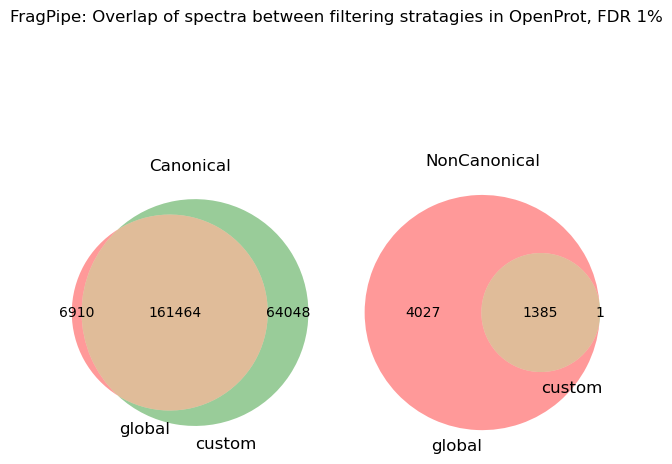

In [182]:
data=pd.concat([subdict["openprot"] for dataset, subdict in prophet_combined_datasets.items()])
data=data[data.isCanonical!="Contam"]

fig, axes = plt.subplots(1,2, figsize=(6, 6))
fig.suptitle("FragPipe: Overlap of spectra between filtering stratagies in OpenProt, FDR 1%")

for i,(isCanonical,group) in enumerate(data.groupby("isCanonical")):
    glob=group[group['global_q']<0.01].spectrum
    cust=group[group['custom_q']<0.01].spectrum
    venn2((set(glob), set(cust)), set_labels=('global', 'custom'), ax=axes[i])
    axes[i].set_title(f"{isCanonical}")
plt.tight_layout()
plt.savefig("./oui_discovery_gwalk_subfigures/fragpipe_global_custom_spectra_overlap.svg", bbox_inches = 'tight')

### Filter by hybrid q-value, decoy and contaminants

In [21]:
prophet_filt_combined_datasets={"PXD002057":{},"PXD005833":{},"PXD014258":{}}
for dataset_name in prophet_combined_datasets:
    for database in prophet_combined_datasets[dataset_name]:
        df=prophet_combined_datasets[dataset_name][database]
        prophet_filt_combined_datasets[dataset_name][database]=df.loc[(df['glob_cust_hybrid']<0.01)&(df.isCanonical!="Contam")&(df["hit_class"]!="D"),:]

In [22]:
pickle.dump(prophet_filt_combined_datasets,open("msfr_prophet_filt_combined_datasets.pkl","wb"))

### Identification rate by search

In [23]:
#as tpp does not record spectra file (but merged, input), then add up corresponding merged files n of spectra

#PXD014258
mgfspectraN_datasets['PXD014258.v0.11.4']={f"{i}.mgf":np.sum([mgfspectraN_datasets['PXD014258.v0.11.4'][f"{i}{j}.RAW.mgf"] for j in range(1,6)]) 
     if "BT474" not in i 
    else np.sum([mgfspectraN_datasets['PXD014258.v0.11.4'][f"{i}_{j}.RAW.mgf"] for j in range(1,6)])
     for i in ["ESC-HF-Sample-BT474","ESC-HF-SampleHela","ESC-HF-Sample-MCF"]
}

In [24]:
del mgfspectraN_datasets['PXD003594.v0.11.4']

In [25]:
#ID rate on target, filtered

prophet_idrate_datasets={"PXD002057":0,"PXD005833":0,"PXD014258":0}
for dataset_name in prophet_filt_combined_datasets:
    idrate_med={"canon":[],"trembl":[],"openprot":[]}
    key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
    mgfspectraN=mgfspectraN_datasets[key]
    for database in idrate_med:
        df=prophet_filt_combined_datasets[dataset_name][database]
        ##dff=df[df["hit_class"]!="D"]
        for spectrum_file, group in df.groupby("spectrum_file"):
            if dataset_name=="PXD014258": spectrum_file=spectrum_file.replace("_","-")
            nspec=mgfspectraN[spectrum_file+".mgf"]
            idrate=(len(group)/nspec)
            idrate_med[database].append(idrate)
    prophet_idrate_datasets[dataset_name]=idrate_med

In [26]:
prophet_idrate_datasets_df=pd.DataFrame(columns=["pipeline","sample","database","value"])
for dataset in prophet_idrate_datasets:
    for database in prophet_idrate_datasets[dataset]:
        for i,val in enumerate(prophet_idrate_datasets[dataset][database]):
            prophet_idrate_datasets_df.loc[len(prophet_idrate_datasets_df)]=["FragPipe",f"{dataset}_{i}",database,val]
prophet_idrate_datasets_df.to_pickle("msfr_idrate_datasets_df.pkl")

### Searches overlap

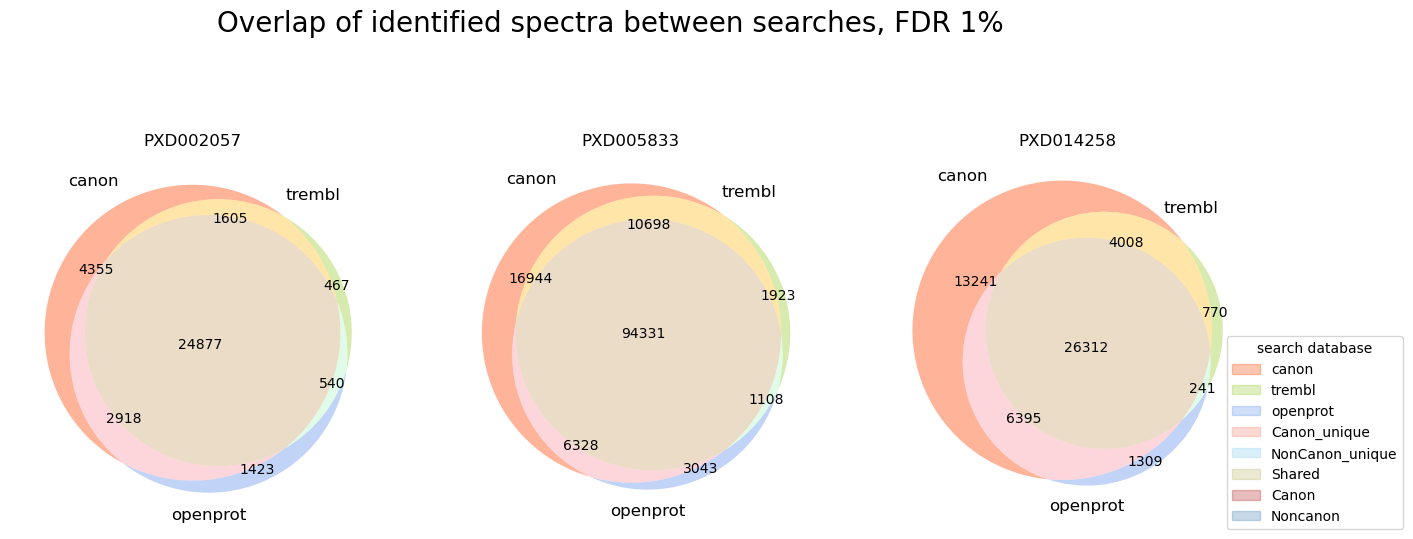

In [27]:
fig, axes = plt.subplots(1, 3, sharey=True,sharex=True, figsize=(16,8))
fig.suptitle('Overlap of identified spectra between searches, FDR 1%',size=20, y=0.9);
for i, dataset_name in enumerate(prophet_filt_combined_datasets):
    dfs=list(prophet_filt_combined_datasets[dataset_name].values())
    databases=list(prophet_filt_combined_datasets[dataset_name].keys())
    venn3([set(dfs[0].spectrum),set(dfs[1].spectrum),set(dfs[2].spectrum)], ax=axes[i],
      set_labels=[databases[0],databases[1],databases[2]], set_colors=(project_palette[databases[0]],project_palette[databases[1]],project_palette[databases[2]]))
    axes[i].set_title(f"{dataset_name}")
p=[]
for l,c in project_palette.items():
    p.append(mpatches.Patch(color=c, label=l,alpha=0.3))  
fig.legend(handles=p, title="search database",loc='upper right',bbox_to_anchor=(1, 0.5));

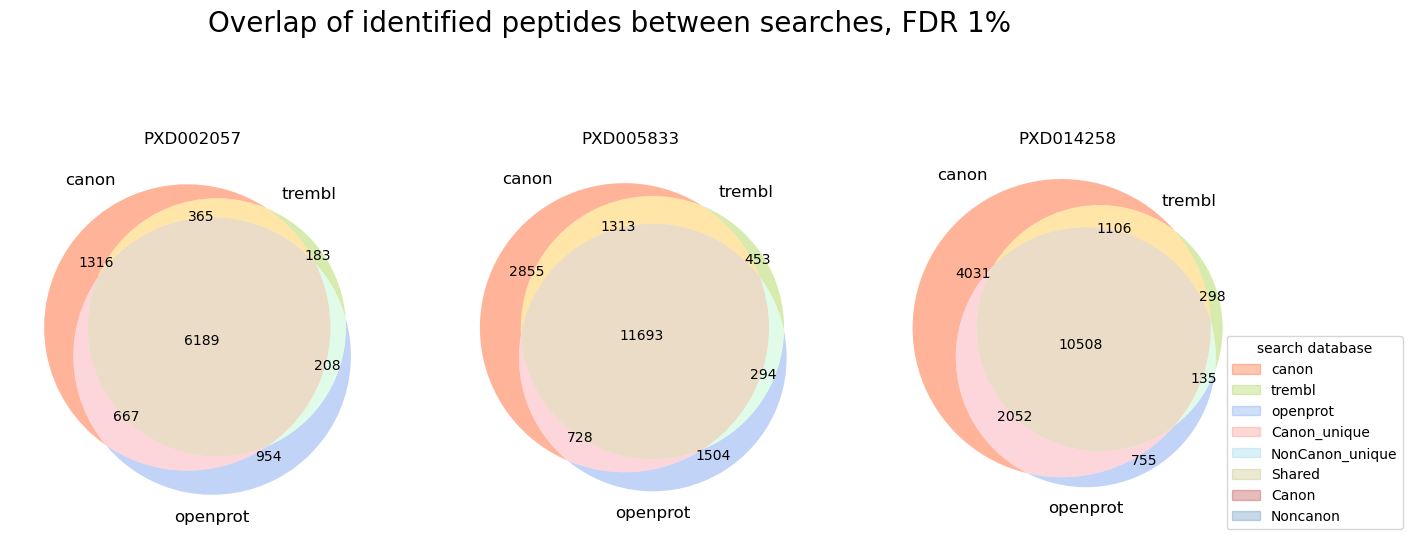

In [28]:
fig, axes = plt.subplots(1, 3, sharey=True,sharex=True, figsize=(16,8))
fig.suptitle('Overlap of identified peptides between searches, FDR 1%',size=20, y=0.9);
for i, dataset_name in enumerate(prophet_filt_combined_datasets):
    dfs=list(prophet_filt_combined_datasets[dataset_name].values())
    databases=list(prophet_filt_combined_datasets[dataset_name].keys())
    venn3([set(dfs[0].peptide),set(dfs[1].peptide),set(dfs[2].peptide)], ax=axes[i],
      set_labels=[databases[0],databases[1],databases[2]], set_colors=(project_palette[databases[0]],project_palette[databases[1]],project_palette[databases[2]]))
    axes[i].set_title(f"{dataset_name}")
p=[]
for l,c in project_palette.items():
    p.append(mpatches.Patch(color=c, label=l,alpha=0.3))  
fig.legend(handles=p, title="search database",loc='upper right',bbox_to_anchor=(1, 0.5));

### Peptide & protein class

In [29]:
#peptides shared vs proteotypic 

pepsharedproteotyp_df=pd.DataFrame(columns=["pipeline","database","peptide_class","value"])
for database in ["canon","trembl","openprot"]:    
    df=pd.concat([prophet_filt_combined_datasets[dataset_name][database] for dataset_name in prophet_filt_combined_datasets])
    ##df=df[(df["hit_class"]!="D")]
    counts=Counter(df.drop_duplicates(["peptide"]).peptide_class)
    pepsharedproteotyp_df.loc[len(pepsharedproteotyp_df)]=["FragPipe",database,"shared",np.sum([val for key,val in counts.items() if "shared" in key])]
    pepsharedproteotyp_df.loc[len(pepsharedproteotyp_df)]=["FragPipe",database,"proteotypic",np.sum([val for key,val in counts.items() if "unique" in key])]
pepsharedproteotyp_df.to_pickle("msfr_peptype_df.pkl")

### Identification rate by peptide class

In [30]:
prophet_PEPCL_idrate_datasets_df=pd.DataFrame(columns=["pipeline","dataset","peptide_class","value"])
pepcl_order=["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']
datasets_index=[f"{dataset_name.replace(".v0.11.4","")}_{i}" for dataset_name,vals in mgfspectraN_datasets.items() for i in range(len(vals))]
prophet_PEPCL_idrate_datasets_df["pipeline"]=["FragPipe"]*len(pepcl_order)*len(datasets_index)
prophet_PEPCL_idrate_datasets_df["dataset"]=datasets_index*len(pepcl_order)
prophet_PEPCL_idrate_datasets_df["peptide_class"]=sorted(pepcl_order*len(datasets_index))

for dataset_name in prophet_filt_combined_datasets:
    key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
    mgfspectraN=mgfspectraN_datasets[key]
    database="openprot"
    df=prophet_filt_combined_datasets[dataset_name][database]
    ##df=df[df["hit_class"]!="D"]
    for peptide_class in pepcl_order:   
        dff=df[df.peptide_class==peptide_class]
        values=[]
        for spectrum_file, _ in df.groupby("spectrum_file"): #to avoid sp files with no pep cl
            group=dff[dff.spectrum_file==spectrum_file]
            print(peptide_class,spectrum_file)
            if len(group)==0: 
                values.append(0)
                continue
            if dataset_name=="PXD014258": spectrum_file=spectrum_file.replace("_","-")
            nspec=mgfspectraN[spectrum_file+".mgf"]
            idrate=(len(group)/nspec)
            values.append(idrate)
        prophet_PEPCL_idrate_datasets_df.loc[(prophet_PEPCL_idrate_datasets_df.dataset.str.contains(dataset_name.replace(".v0.11.4","")))&
            (prophet_PEPCL_idrate_datasets_df.peptide_class==peptide_class),"value"]=values
prophet_PEPCL_idrate_datasets_df.to_pickle("msfr_PEPCL_idrate_datasets_df.pkl")

unique_to_Noncanon 130327_o2_01_hu_C1_2hr
unique_to_Noncanon 130327_o2_02_hu_P1_2hr
unique_to_Noncanon 130327_o2_03_hu_C2_2hr
unique_to_Noncanon 130327_o2_04_hu_P2_2hr
unique_to_Noncanon 130327_o2_05_hu_C3_2hr
unique_to_Noncanon 130327_o2_06_hu_P3_2hr
shared_in_Noncanon 130327_o2_01_hu_C1_2hr
shared_in_Noncanon 130327_o2_02_hu_P1_2hr
shared_in_Noncanon 130327_o2_03_hu_C2_2hr
shared_in_Noncanon 130327_o2_04_hu_P2_2hr
shared_in_Noncanon 130327_o2_05_hu_C3_2hr
shared_in_Noncanon 130327_o2_06_hu_P3_2hr
unique_to_Canon 130327_o2_01_hu_C1_2hr
unique_to_Canon 130327_o2_02_hu_P1_2hr
unique_to_Canon 130327_o2_03_hu_C2_2hr
unique_to_Canon 130327_o2_04_hu_P2_2hr
unique_to_Canon 130327_o2_05_hu_C3_2hr
unique_to_Canon 130327_o2_06_hu_P3_2hr
shared_in_Canon 130327_o2_01_hu_C1_2hr
shared_in_Canon 130327_o2_02_hu_P1_2hr
shared_in_Canon 130327_o2_03_hu_C2_2hr
shared_in_Canon 130327_o2_04_hu_P2_2hr
shared_in_Canon 130327_o2_05_hu_C3_2hr
shared_in_Canon 130327_o2_06_hu_P3_2hr
shared_btw_can_noncan 130327

### Peptides' reproducability

In [31]:
#across all samples

peptides_across_samples_df=pd.DataFrame(columns=["pipeline","peptide","class","value"])
for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:#("Canon_unique", "NonCanon_unique", "Shared"):
    peptides_across_samples_l=[]
    for dataset_name in prophet_filt_combined_datasets:
        df=prophet_filt_combined_datasets[dataset_name]["openprot"]
        df=df[(df["peptide_class"]==peptide_class)]#(df["hit_class"]!="D")&
        peptides_across_samples_l=peptides_across_samples_l+list(df.drop_duplicates(["peptide","spectrum_file"]).peptide)
    
    peptides_across_samples_d=Counter(peptides_across_samples_l)
    peptides_across_samples=np.array(list(peptides_across_samples_d.values()))/23 #number of samples
    keys=list(peptides_across_samples_d.keys())
    for i,row in enumerate(peptides_across_samples):
        peptides_across_samples_df.loc[len(peptides_across_samples_df)]=["FragPipe",keys[i],peptide_class,row]
peptides_across_samples_df.to_pickle("msfr_peptides_across_samples_df.pkl")

In [32]:
#across samples of same PXD

peptides_across_samples_PXD_df=pd.DataFrame(columns=["pipeline","peptide","class","value"])
for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:#("Canon_unique", "NonCanon_unique", "Shared"):
    #peptides_across_samples_l=[]
    for dataset_name in prophet_filt_combined_datasets:
        key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
        mgfspectraN=mgfspectraN_datasets[key]
        df=prophet_filt_combined_datasets[dataset_name]["openprot"]
        df=df[(df["peptide_class"]==peptide_class)] #(df["hit_class"]!="D")&
        peptides_across_samples_l=list(df.drop_duplicates(["peptide","spectrum_file"]).peptide)
    
        peptides_across_samples_d=Counter(peptides_across_samples_l)
        peptides_across_samples=np.array(list(peptides_across_samples_d.values()))/len(mgfspectraN) #number of samples
        keys=list(peptides_across_samples_d.keys())
        for i,row in enumerate(peptides_across_samples):
            peptides_across_samples_PXD_df.loc[len(peptides_across_samples_PXD_df)]=["FragPipe",keys[i],peptide_class,row]
peptides_across_samples_PXD_df.to_pickle("msfr_peptides_across_samples_PXD_df.pkl")

In [33]:
#count by PXD

peptides_across_samples_PEP_df=pd.DataFrame(columns=["pipeline","PXD","peptide_class","value","count"])
for dataset_name in prophet_filt_combined_datasets:
    for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:#("Canon_unique", "NonCanon_unique", "Shared"):
        df=prophet_filt_combined_datasets[dataset_name]["openprot"]
        df=df[(df["peptide_class"]==peptide_class)] #(df["hit_class"]!="D")&
        peptides_across_samples_l=list(df.peptide.unique())
        tmp=pd.DataFrame(index=peptides_across_samples_l,columns=df.spectrum_file.unique())
        for spectrum_file in tmp.columns:
            tmp[spectrum_file]=[pep in df[df.spectrum_file==spectrum_file].peptide.unique() for pep in tmp.index]
        tmp["count"]=tmp.apply(lambda x: Counter(x)[True] ,axis=1)
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["FragPipe",dataset_name,peptide_class,1,len(tmp[tmp["count"]==1])]
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["FragPipe",dataset_name,peptide_class,2,len(tmp[tmp["count"]==2])]
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["FragPipe",dataset_name,peptide_class,3,len(tmp[tmp["count"]==3])]
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["FragPipe",dataset_name,peptide_class,4,len(tmp[tmp["count"]>3])]

In [34]:
#add all

for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:
    df=pd.concat([prophet_filt_combined_datasets[dataset_name]["openprot"] for dataset_name in prophet_filt_combined_datasets])
    df=df[(df["peptide_class"]==peptide_class)]#(df["hit_class"]!="D")&
    peptides_across_samples_l=list(df.peptide.unique())
    tmp=pd.DataFrame(index=peptides_across_samples_l,columns=df.spectrum_file.unique())
    for spectrum_file in tmp.columns:
        tmp[spectrum_file]=[pep in df[df.spectrum_file==spectrum_file].peptide.unique() for pep in tmp.index]
    tmp["count"]=tmp.apply(lambda x: Counter(x)[True] ,axis=1)
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["FragPipe","all",peptide_class,1,len(tmp[tmp["count"]==1])]
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["FragPipe","all",peptide_class,2,len(tmp[tmp["count"]==2])]
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["FragPipe","all",peptide_class,3,len(tmp[tmp["count"]==3])]
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["FragPipe","all",peptide_class,4,len(tmp[tmp["count"]>3])]

In [35]:
peptides_across_samples_PEP_df.to_pickle("msfr_peptides_across_samples_PEP_df.pkl")

### Number of PSMs per peptide class

In [36]:
pepcl_psm_frq={"peptide":[],"peptide_class":[],"psm_num":[]}
for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:
    peps_dst=[]
    for dataset_name in prophet_filt_combined_datasets:
        df=prophet_filt_combined_datasets[dataset_name]["openprot"]
        df=df[(df["peptide_class"]==peptide_class)] #(df["hit_class"]!="D")&
        peps_dst=peps_dst+list(df.peptide)
    psm_dfs=pd.concat([subdict["openprot"] for dataset,subdict in prophet_filt_combined_datasets.items()])
    peps_count=Counter(psm_dfs[psm_dfs.peptide.isin(peps_dst)].peptide)
    peps_count_v=list(list(peps_count.values()))
    pepcl_psm_frq["peptide"]=pepcl_psm_frq["peptide"]+list(list(peps_count.keys()))
    pepcl_psm_frq["peptide_class"]=pepcl_psm_frq["peptide_class"]+[peptide_class]*len(peps_count_v)
    pepcl_psm_frq["psm_num"]=pepcl_psm_frq["psm_num"]+[p for p in peps_count_v]
pepcl_psm_frq=pd.DataFrame(pepcl_psm_frq)

In [37]:
pepcl_psm_frq["pipeline"]="FragPipe"
pepcl_psm_frq["bin"]=np.nan
for bin,group in enumerate([[1],[2],list(range(3,5+1)),list(range(5,10+1)),list(range(10,15+1)),list(range(15,1000))]):
    pepcl_psm_frq.loc[pepcl_psm_frq.psm_num.isin(group),"bin"]=bin
pepcl_psm_frq.to_pickle("msfr_pepcl_psm_frq.pkl")

#### Save into table to do protein inference with ionbot pipeline

In [39]:
#unfiltered
for dataset, subdict in prophet_combined_datasets.items():
    for database,data in subdict.items():
        data["searchDB"]=database
        data["PXD"]=dataset
        directory=f"./hybrid-psm-fragpipe/{dataset}/{dataset}-{database}/"
        if not os.path.exists(directory):
            os.makedirs(directory)
        for spectrum_file,group in data.groupby("spectrum_file"):
            group.to_csv(f"{directory}{spectrum_file.replace('.mgf','')}.csv",index=False)

### Proteins

In [42]:
protein_gr_file="./fragpipe-identified-protein-groups-all-datasets.csv.gz"
combined_proteins_ocacam=pd.read_csv(protein_gr_file)

In [43]:
combined_proteins_ocacam.columns

Index(['proteins', 'database',
       'analysis_result:peptideprophet_result:parameter:fval', 'experiment',
       'exp_number', 'PXD', 'searchDB', 'is decoy', 'global_q', 'isCanonical',
       'isModified', 'groupwise_qvalue'],
      dtype='object')

In [46]:
#put hybrid q-value
combined_proteins_ocacam["glob_cust_hybrid"]=combined_proteins_ocacam.apply(lambda x: x.groupwise_qvalue if x.isCanonical=="NonCanonical" else x.global_q, axis=1)

In [50]:
to_fix={}
for experiment in combined_proteins_ocacam.experiment.unique():
    if "Sample" in experiment:
        spectrum_file=experiment+"_merged.mgf"
    else:
        spectrum_file=experiment+".mgf"
    to_fix.update({experiment:spectrum_file})
combined_proteins_ocacam["spectrum_file"]=combined_proteins_ocacam.experiment.map(to_fix)

In [52]:
prophet_mega=pd.concat([prophet_combined_datasets[dataset]["openprot"] for dataset in prophet_combined_datasets.keys()])

In [53]:
#filtered?
combined_proteins_ocacam['glob_cust_hybrid'].max()

0.5

In [54]:
#filter by qval
combined_proteins_ocacam=combined_proteins_ocacam[combined_proteins_ocacam['glob_cust_hybrid']<0.01]

In [55]:
#drop decoys
combined_proteins_ocacam=combined_proteins_ocacam[combined_proteins_ocacam.database!="D"]

In [56]:
combined_proteins_ocacam.searchDB.unique()

array(['canon', 'trembl', 'openprot'], dtype=object)

In [57]:
combined_proteins_ocacam[['database', 'spectrum_file', 'PXD','searchDB','isCanonical']].value_counts()

database  spectrum_file                   PXD        searchDB  isCanonical 
T         AM16.mgf                        PXD005833  canon     Canonical       1635
          ESC_HF_Sample_BT474_merged.mgf  PXD014258  canon     Canonical       1588
          AM16.mgf                        PXD005833  trembl    Canonical       1405
          ESC_HF_Sample_MCF_merged.mgf    PXD014258  canon     Canonical       1402
          AM16.mgf                        PXD005833  openprot  Canonical       1399
                                                                               ... 
          ESC_HF_Sample_MCF_merged.mgf    PXD014258  openprot  NonCanonical      11
          AM7.mgf                         PXD005833  openprot  NonCanonical      10
          AM18.mgf                        PXD005833  openprot  NonCanonical       8
          ESC_HF_SampleHela_merged.mgf    PXD014258  openprot  NonCanonical       5
          ESC_HF_Sample_BT474_merged.mgf  PXD014258  openprot  NonCanonical       5


In [59]:
#classify: 1 protein/group

combined_proteins_ocacam["level"]=np.nan
for (PXD, spectrum_file, database ), group in combined_proteins_ocacam.groupby(['PXD','spectrum_file','searchDB',]):
    combined_proteins_ocacam.loc[(combined_proteins_ocacam.PXD==PXD)&(
        combined_proteins_ocacam.spectrum_file==spectrum_file)&(
        combined_proteins_ocacam.searchDB==database),"level"]=group.proteins.apply(lambda x: "Group" if "," in x else "Singleton")

In [60]:
combined_proteins_ocacam[["searchDB","level"]].value_counts()

searchDB  level    
canon     Singleton    23954
openprot  Group        19863
trembl    Group        16413
          Singleton     6302
openprot  Singleton     3732
canon     Group         2061
Name: count, dtype: int64

In [61]:
combined_proteins_ocacam[combined_proteins_ocacam.searchDB.str.contains("open")].drop_duplicates("proteins")[["isCanonical","level"]].value_counts()

isCanonical   level    
Canonical     Group        16485
              Singleton      888
NonCanonical  Singleton      239
              Group            9
Name: count, dtype: int64

In [62]:
combined_proteins_ocacam.to_pickle("fragpipe_combined_proteins_ocacam.pickle")

In [70]:
def get_nonc_prots(pep_df):
    return list(set([p for p in pep_df[pep_df.peptide_class.isin(["unique_to_Noncanon"])].proteins]))

In [142]:
combined_proteins_ocacam_newop=combined_proteins_ocacam.copy(deep=True)
#filter out noncanonical proteins from combined_proteins_ocacam
for (dataset,spectrum_file),group in combined_proteins_ocacam[combined_proteins_ocacam.searchDB=="openprot"].groupby(["PXD","spectrum_file"]):
    #print(spectrum_file)
    spectrum_file_mod=spectrum_file.replace("_merged.mgf","").replace(".mgf","")#.rstrip(".gzip").replace("-openprot","").replace("_openprot","")
    drop_op=group[(group.isCanonical=="NonCanonical")].index
    #combined_proteins_ocacam_newop.drop(drop_op,axis=0,inplace=True)
    pep_df=prophet_filt_combined_datasets[dataset]["openprot"]
    pep_df=pep_df[pep_df.peptide_class!="Decoy"]
    op_ncprot=get_nonc_prots(pep_df.loc[pep_df.spectrum_file.str.contains(spectrum_file_mod)])
    tmp=pd.DataFrame({col:(op_ncprot if col=="proteins" 
                           else [dataset]*len(op_ncprot) if col=="PXD" 
                           else [spectrum_file]*len(op_ncprot) if col=="spectrum_file"
                           else ["NonCanonical"]*len(op_ncprot) if col=="isCanonical"
                           else ["openprot"]*len(op_ncprot) if col=="searchDB"
                           else ["Singleton"]*len(op_ncprot) if col=="level"
                           else ["T"]*len(op_ncprot) if col=="database"
                           else [np.nan]*len(op_ncprot)) for col in group.columns})
    print(spectrum_file,len(tmp))
    combined_proteins_ocacam_newop=pd.concat([combined_proteins_ocacam_newop,tmp])
combined_proteins_ocacam_newop.reset_index(drop=True,inplace=True)

130327_o2_01_hu_C1_2hr.mgf 53
130327_o2_02_hu_P1_2hr.mgf 68
130327_o2_03_hu_C2_2hr.mgf 65
130327_o2_04_hu_P2_2hr.mgf 75
130327_o2_05_hu_C3_2hr.mgf 73
130327_o2_06_hu_P3_2hr.mgf 56
AM10.mgf 26
AM11.mgf 34
AM12.mgf 34
AM13.mgf 37
AM14.mgf 80
AM15.mgf 40
AM16.mgf 47
AM17.mgf 30
AM18.mgf 18
AM19.mgf 42
AM20.mgf 40
AM21.mgf 32
AM7.mgf 22
AM8.mgf 44
AM9.mgf 43
ESC_HF_SampleHela_merged.mgf 13
ESC_HF_Sample_BT474_merged.mgf 17
ESC_HF_Sample_MCF_merged.mgf 28


In [143]:
#drop previous non-canonical proteins

combined_proteins_ocacam_newop=combined_proteins_ocacam_newop[~((combined_proteins_ocacam_newop.isCanonical=="NonCanonical")&(combined_proteins_ocacam_newop.experiment.isna()==False))]

In [144]:
#also drop non-canonical proteins from Groups, because we concider them non-identified on protein level

for i,row in combined_proteins_ocacam_newop.iterrows():
    if row["level"]=="Group":
        nc=[ prot.startswith(("IP_","II_")) for prot in row["proteins"].split(",")]
        if all(nc): #delet nc groups
            combined_proteins_ocacam_newop.drop(i,axis=0,inplace=True)
        else:
            combined_proteins_ocacam_newop.loc[i,"proteins"]=",".join([prot for prot,isnc in zip(row["proteins"].split(","),nc) if not isnc])

In [145]:
# Number of proteins identified with FragPipe by search

bysearch_proteins=pd.DataFrame(columns=["pipeline","database","group","value"])
for database,group in combined_proteins_ocacam_newop.groupby("searchDB"):
    group_sing=group[group.level=="Singleton"]
    group_uplim=group[group.level=="Group"]
    singletons=set(group_sing.proteins.tolist())
    uplim=set([p for g in group_uplim.proteins.tolist() for p in g.split(",")])
    print(database,len(singletons),len(uplim-singletons))
    bysearch_proteins.loc[len(bysearch_proteins)]=["FragPipe",database,"singletons",len(singletons)]
    bysearch_proteins.loc[len(bysearch_proteins)]=["FragPipe",database,"indistinguishable proteins",len(uplim-singletons)]
bysearch_proteins.to_pickle("fragpipe_bysearch_proteins.pkl")

canon 3684 479
openprot 1296 22528
trembl 1252 12994


### Proteins reproducability

In [146]:
#across all samples 

prot_reproduce_FragPipe=pd.DataFrame(columns=["pipeline","database","level","protein","frequency"]);
for database, group in combined_proteins_ocacam_newop.groupby(["searchDB"]):
    group.drop_duplicates(["proteins","spectrum_file"],inplace=True)
    group_sig=group[group.level=="Singleton"]    
    counts_sig=group_sig.proteins.value_counts().to_dict()
    frq_sig={p:n/24 for p,n in counts_sig.items()}
    prot_sing=set(counts_sig.keys())
    #it treaky, because in different samples protein can be in group of several entries
    group_uplim=group[group.level=="Group"]
    prot_uplim_exp={file:set([p for i,row in sub.iterrows() for p in row["proteins"].split(",")]) for file,sub in group_uplim.groupby("spectrum_file")}
    #subtract singeltons
    prot_uplim_corr={file:list(prots-set(group_sig[group_sig.spectrum_file==file].proteins.tolist())) for file,prots in prot_uplim_exp.items()}      
    #unlist
    counts_uplim=Counter([el for l in prot_uplim_corr.values() for el in l])
    frq_uplim={p:n/24 for p,n in counts_uplim.items()}
    L=len(frq_sig)+len(frq_uplim)
    tmp={"pipeline":["FragPipe"]*L,"database":[database[0]]*L,"level":["razor"]*len(frq_sig)+["from group"]*len(frq_uplim),
         "protein":list(frq_sig.keys())+list(frq_uplim.keys()),"frequency":list(frq_sig.values())+list(frq_uplim.values())
        }
    prot_reproduce_FragPipe=pd.concat([prot_reproduce_FragPipe,pd.DataFrame(tmp)])

In [147]:
prot_reproduce_FragPipe.to_pickle("fragpipe_prot_reproduce.pkl")

In [148]:
#across samples of same PXD

prot_reproduce_PXD_FragPipe=pd.DataFrame(columns=["pipeline","database","level","protein","frequency"]);
for (database, PXD), group_pxd in combined_proteins_ocacam_newop.groupby(["searchDB","PXD"]):
    group_pxd.drop_duplicates(["proteins","spectrum_file"],inplace=True)
    group_sig=group_pxd[group_pxd.level=="Singleton"]    
    counts_sig=group_sig.proteins.value_counts().to_dict()
    key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
    mgfspectraN=mgfspectraN_datasets[key]
    frq_sig={p:n/len(mgfspectraN) for p,n in counts_sig.items()}
    prot_sing=set(counts_sig.keys())
    #it treaky, because in different samples protein can be in group of several entries
    group_uplim=group_pxd[group_pxd.level=="Group"]
    prot_uplim_exp={file:set([p for i,row in sub.iterrows() for p in row["proteins"].split(",")]) for file,sub in group_uplim.groupby("spectrum_file")}
    #subtract singeltons
    prot_uplim_corr={file:list(prots-set(group_sig[group_sig.spectrum_file==file].proteins.tolist())) for file,prots in prot_uplim_exp.items()}      
    #unlist
    counts_uplim=Counter([el for l in prot_uplim_corr.values() for el in l])
    frq_uplim={p:n/len(mgfspectraN) for p,n in counts_uplim.items()}
    L=len(frq_sig)+len(frq_uplim)
    tmp={"pipeline":["FragPipe"]*L,"database":[database]*L,"level":["razor"]*len(frq_sig)+["from group"]*len(frq_uplim),
         "protein":list(frq_sig.keys())+list(frq_uplim.keys()),"frequency":list(frq_sig.values())+list(frq_uplim.values())
        }
    prot_reproduce_PXD_FragPipe=pd.concat([prot_reproduce_PXD_FragPipe,pd.DataFrame(tmp)])

In [149]:
prot_reproduce_PXD_FragPipe.to_pickle("fragpipe_prot_reproduce_PXD.pkl")

In [150]:
#across samples of same PXD, counts

values=list(range(1,4))
prot_reproduce_PXD_FragPipe_counts=pd.DataFrame(columns=["pipeline","PXD","database","level","value","count"])
for (database, PXD), group_pxd in combined_proteins_ocacam_newop.groupby(["searchDB","PXD"]):
    group_pxd.drop_duplicates(["proteins","spectrum_file"],inplace=True)
    group_sig=group_pxd[group_pxd.level=="Singleton"]    
    counts_sig=group_sig.proteins.value_counts().to_dict()
    key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
    mgfspectraN=mgfspectraN_datasets[key]
    frq_sig={p:n for p,n in counts_sig.items()}
    prot_sing=set(counts_sig.keys())
    #it treaky, because in different samples protein can be in group of several entries
    group_uplim=group_pxd[group_pxd.level=="Group"]
    prot_uplim_exp={file:set([p for i,row in sub.iterrows() for p in row["proteins"].split(",")]) for file,sub in group_uplim.groupby("spectrum_file")}
    #subtract singeltons
    prot_uplim_corr={file:list(prots-set(group_sig[group_sig.spectrum_file==file].proteins.tolist())) for file,prots in prot_uplim_exp.items()}      
    #unlist
    counts_uplim=Counter([el for l in prot_uplim_corr.values() for el in l])
    frq_uplim={p:n for p,n in counts_uplim.items()}
    ###L=len(frq_sig)+len(frq_uplim)
    value_counts_sig=Counter(list(frq_sig.values()))
    value_counts_uplim=Counter(list(frq_uplim.values()))
    L=len(values)*2
    tmp={"pipeline":["FragPipe"]*L,"PXD":[PXD.replace("-closed","")]*L,"database":[database]*L,"level":["razor"]*len(values)+["from group"]*len(values),"value":values*2,
         "count":[value_counts_sig[i] if i<3 else np.sum([v for k,v in value_counts_sig.items() if k>=3]) for i in values]+[value_counts_uplim[i] if i<3 else np.sum([v for k,v in value_counts_uplim.items() if k>=3]) for i in values]
        }
    #break
    prot_reproduce_PXD_FragPipe_counts=pd.concat([prot_reproduce_PXD_FragPipe_counts,pd.DataFrame(tmp)])

In [151]:
#add all

values=list(range(1,4))
for (database,level),group in prot_reproduce_FragPipe.groupby(["database","level"]):
    counts={k*24:v for k,v in dict(group.frequency.value_counts()).items()}
    L=len(values)
    tmp={"pipeline":["FragPipe"]*L,"PXD":["all"]*L,"database":[database]*L,"level":[level]*len(values),"value":values,
         "count":[0 if i not in counts.keys() else counts[i] if i<3 else np.sum([v for k,v in counts.items() if k>=3]) for i in values]
        }
    prot_reproduce_PXD_FragPipe_counts=pd.concat([prot_reproduce_PXD_FragPipe_counts,pd.DataFrame(tmp)])

In [152]:
prot_reproduce_PXD_FragPipe_counts.to_pickle("fragpipe_protrepr_PXD_counts.pkl")

In [153]:
#across samples of same PXD, counts BY PROTEIN CLASS, singeltons

values=list(range(1,4))
prot_reproduce_PXD_FragPipe_protcl_counts=pd.DataFrame(columns=["pipeline","PXD","isCanonical","level","value","count"])
for (isCanonical, PXD), group_pxd in combined_proteins_ocacam_newop.groupby(["isCanonical","PXD"]):
    group_pxd.drop_duplicates(["proteins","spectrum_file"],inplace=True)
    group_sig=group_pxd[group_pxd.level=="Singleton"]    
    counts_sig=group_sig.proteins.value_counts().to_dict()
    prot_sing=Counter(counts_sig.values())
    L=len(values)
    tmp={"pipeline":["FragPipe"]*L,"PXD":[PXD.replace("-closed","")]*L,"isCanonical":[isCanonical]*L,"level":["razor"]*L,"value":values,
         "count":[prot_sing[i] if i<3 else np.sum([v for k,v in prot_sing.items() if k>=3]) for i in values]
        }
    prot_reproduce_PXD_FragPipe_protcl_counts=pd.concat([prot_reproduce_PXD_FragPipe_protcl_counts,pd.DataFrame(tmp)])

In [154]:
#add all

values=list(range(1,4))
for isCanonical, group_pxd in combined_proteins_ocacam_newop.groupby(["isCanonical"]):
    group_pxd.drop_duplicates(["proteins","spectrum_file"],inplace=True)
    group_sig=group_pxd[group_pxd.level=="Singleton"]    
    counts_sig=group_sig.proteins.value_counts().to_dict()
    prot_sing=Counter(counts_sig.values())
    L=len(values)
    tmp={"pipeline":["FragPipe"]*L,"PXD":["all"]*L,"isCanonical":[isCanonical[0]]*L,"level":["razor"]*L,"value":values,
         "count":[prot_sing[i] if i<3 else np.sum([v for k,v in prot_sing.items() if k>=3]) for i in values]
        }
    prot_reproduce_PXD_FragPipe_protcl_counts=pd.concat([prot_reproduce_PXD_FragPipe_protcl_counts,pd.DataFrame(tmp)])

In [155]:
prot_reproduce_PXD_FragPipe_protcl_counts.to_pickle("fragpipe_prot_reproduce_PXD_fragpipe_protcl_counts.pkl")

### Number of proteins per protein class

In [156]:
byprotclass_proteins=pd.DataFrame(columns=["pipeline","search","protein_class","group","value"])
for (search,protein_class),group in combined_proteins_ocacam_newop.groupby(["searchDB","isCanonical"]):
    group_sing=group[group.level=="Singleton"]
    group_uplim=group[group.level=="Group"]
    singletons=set(group_sing.proteins.tolist())
    uplim=set([p for g in group_uplim.proteins.tolist() for p in g.split(",")])
    byprotclass_proteins.loc[len(byprotclass_proteins)]=["FragPipe",search,protein_class,"singletons",len(singletons)]
    byprotclass_proteins.loc[len(byprotclass_proteins)]=["FragPipe",search,protein_class,"indistinguishable proteins",len(uplim-singletons)]
byprotclass_proteins.to_pickle("fragpipe_byprotclass_proteins.pkl")

### Number of peptides & PSMs per protein per protein class

In [157]:
#combine PSM level data in OpenProt search

prophet_op=pd.concat([prophet_filt_combined_datasets[dataset]["openprot"] for dataset in prophet_filt_combined_datasets])

In [158]:
# Repeat PSM for each protein in group in OpenProt search

prophet_op['proteins_expand']= prophet_op.proteins.apply(lambda x: x.split("||"))
prophet_op = prophet_op.explode('proteins_expand').reset_index(drop=True)

In [159]:
# Repeat protein for each protein in group

combined_proteins_ocacam_newop['proteins_expand'] = combined_proteins_ocacam_newop.proteins.apply(lambda x: x.split(","))
all_prot_msfr_filt = combined_proteins_ocacam_newop.explode('proteins_expand').reset_index(drop=True)

In [160]:
def get_frompepdf_pepcounts_msfr(pep_df,peptide_class,proteins):
    d=dict(zip(set(proteins),[0]*len(set(proteins))))
    cl_pep_df=pep_df[(pep_df.peptide_class==peptide_class)&(pep_df.proteins_expand.isin(set(proteins)))]
    cl_pep_df.drop_duplicates(["peptide","proteins_expand"],keep="first",inplace=True)
    cl_pep_df_counts=Counter(cl_pep_df.proteins_expand.tolist())
    d.update(cl_pep_df_counts)
    return  d
    
def get_frompsmdf_psmcounts_msfr(pep_df,peptide_class,proteins):
    d=dict(zip(set(proteins),[0]*len(set(proteins))))
    cl_pep_df=pep_df[(pep_df.peptide_class==peptide_class)&(pep_df.proteins_expand.isin(set(proteins)))]
    cl_pep_df_counts=Counter(cl_pep_df.proteins_expand.tolist())
    d.update(cl_pep_df_counts)
    return  d

In [161]:
all_prot_msfr_filt.columns

Index(['proteins', 'database',
       'analysis_result:peptideprophet_result:parameter:fval', 'experiment',
       'exp_number', 'PXD', 'searchDB', 'is decoy', 'global_q', 'isCanonical',
       'isModified', 'groupwise_qvalue', 'glob_cust_hybrid', 'spectrum_file',
       'level', 'proteins_expand'],
      dtype='object')

In [162]:
columns=["proteins_","protein_class","unique_to_class",'shared_in_class','shared_btw_classes']
proteins_pep_df=pd.DataFrame(columns=columns)
proteins_psm_df=pd.DataFrame(columns=columns)

for protein_class,group in all_prot_msfr_filt[all_prot_msfr_filt.searchDB=="openprot"].groupby("isCanonical"):
    if protein_class=="Canonical": pep_class_pref="Canon"                
    elif protein_class=="NonCanonical": pep_class_pref="Noncanon"
    proteins=set(group[group.level=="Singleton"].proteins_expand.tolist()+group[group.level=="Group"].proteins_expand.tolist())
    print("add prots",len(list(set(proteins))))
    #pep
    cl_unique_pep_df_counts=get_frompepdf_pepcounts_msfr(prophet_op,f"unique_to_{pep_class_pref}",proteins)
    cl_shin_pep_df_counts=get_frompepdf_pepcounts_msfr(prophet_op,f"shared_in_{pep_class_pref}",proteins)
    cl_shared_pep_df_counts=get_frompepdf_pepcounts_msfr(prophet_op,"shared_btw_can_noncan",proteins)
    print("add pep counts",len(cl_shared_pep_df_counts))
    add_pr=set(proteins)
    prot_pep_df=pd.DataFrame({"proteins_":list(add_pr),"protein_class":[protein_class]*len(add_pr),
                 "unique_to_class":list(cl_unique_pep_df_counts.values()),
                "shared_in_class":list(cl_shin_pep_df_counts.values()),
                 "shared_btw_classes":list(cl_shared_pep_df_counts.values())})
    
    proteins_pep_df=pd.concat([proteins_pep_df,prot_pep_df])
    print(proteins_pep_df.head())
    #psm    
    cl_unique_psm_df_counts=get_frompsmdf_psmcounts_msfr(prophet_op,f"unique_to_{pep_class_pref}",proteins)
    cl_shin_psm_df_counts=get_frompsmdf_psmcounts_msfr(prophet_op,f"shared_in_{pep_class_pref}",proteins)
    cl_shared_psm_df_counts=get_frompsmdf_psmcounts_msfr(prophet_op,"shared_btw_can_noncan",proteins)
    prot_psm_df=pd.DataFrame({"proteins_":list(add_pr),"protein_class":[protein_class]*len(add_pr),
                 "unique_to_class":list(cl_unique_psm_df_counts.values()),
                "shared_in_class":list(cl_shin_psm_df_counts.values()),
                 "shared_btw_classes":list(cl_shared_psm_df_counts.values())})
    proteins_psm_df=pd.concat([proteins_psm_df,prot_psm_df])

add prots 23416


/tmp/ipykernel_533673/762099954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cl_pep_df.drop_duplicates(["peptide","proteins_expand"],keep="first",inplace=True)


add pep counts 23416
    proteins_ protein_class unique_to_class shared_in_class shared_btw_classes
0  A0A8I5KVH4     Canonical               0               0                  2
1      B4DFK1     Canonical               0               0                  3
2  A0A7I2V474     Canonical               0               1                  0
3      Q7Z406     Canonical               0               0                 31
4      E7EQT4     Canonical               0               3                  1
add prots 408


/tmp/ipykernel_533673/762099954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cl_pep_df.drop_duplicates(["peptide","proteins_expand"],keep="first",inplace=True)


add pep counts 408
    proteins_ protein_class unique_to_class shared_in_class shared_btw_classes
0  A0A8I5KVH4     Canonical               0               0                  2
1      B4DFK1     Canonical               0               0                  3
2  A0A7I2V474     Canonical               0               1                  0
3      Q7Z406     Canonical               0               0                 31
4      E7EQT4     Canonical               0               3                  1


In [163]:
proteins_pep_df.to_pickle("msfr_proteins_pep_df.pkl")
proteins_psm_df.to_pickle("msfr_proteins_psm_df.pkl")

In [164]:
proteins_pep_df["tot"]=proteins_pep_df[["unique_to_class",	"shared_in_class",	"shared_btw_classes"]].sum(axis=1)
proteins_psm_df["tot"]=proteins_psm_df[["unique_to_class",	"shared_in_class",	"shared_btw_classes"]].sum(axis=1)

In [165]:
(proteins_pep_df.tot==0).value_counts()

tot
False    23824
Name: count, dtype: int64

In [166]:
(proteins_psm_df.tot==0).value_counts()

tot
False    23824
Name: count, dtype: int64

### Proteotypic peptides coverage

In [167]:
# Repeat protein for each protein in group
#--do I need to repeat expand?
proteins_op=combined_proteins_ocacam_newop[combined_proteins_ocacam_newop.searchDB=="openprot"]
proteins_op['proteins_expand'] = proteins_op.proteins.apply(lambda x: x.split(","))
proteins_op = proteins_op.explode('proteins_expand').reset_index(drop=True)

/tmp/ipykernel_533673/3503521904.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proteins_op['proteins_expand'] = proteins_op.proteins.apply(lambda x: x.split(","))


In [168]:
all_peptide_sequences=pickle.load(open('./../all_peptide_sequences_OP_7302.pkl', 'rb'))
is_unique=pickle.load(open('./../is_unique_OP_7302.pkl', 'rb'))

In [169]:
#Load OpenProt database

#OPfasta_file='./ionbot_openprot/openprot_2_0_0-human-ensembl106+refseq+uniprot2022_06_01.fasta'
OPfasta_file="/project/def-marie87/vvshazia/pride_reanalysis/msfragger_pride_reanalysis/concatenated-fastas/20241102-openprot-database_ionbot_db/concat.fasta"
input_file = open(OPfasta_file)
OPfasta = SeqIO.to_dict(SeqIO.parse(OPfasta_file, "fasta"))

In [170]:
prophet_filt_op=prophet_op.copy(deep=True)
#Drop PSMs to same peptide and protein
prophet_filt_op.drop_duplicates(["peptide","proteins_expand"],inplace=True,keep="first")

In [171]:
#take only inferred proteins
prophet_filt_op=prophet_filt_op[prophet_filt_op.proteins_expand.isin(proteins_op.proteins_expand.tolist())]

In [172]:
#no decoys
prophet_filt_op=prophet_filt_op[prophet_filt_op.hit_class!="D"]

In [173]:
prophet_filt_op.hit_class.unique()

array(['T', 'NC'], dtype=object)

In [174]:
#filterout non-proteotypic peptides
prophet_filt_op["shared"]=prophet_filt_op["proteins"].apply(lambda x: len(x.split(","))>1 )
#Leave only proteotypic peptides
prophet_filt_op=prophet_filt_op[prophet_filt_op.shared==False]

In [175]:
#get the peptides' positions in proteins

count_var=0
prophet_filt_op["peptide_position"]='nan'
for i,row in prophet_filt_op.iterrows():
    peptide=row["peptide"]; prot=row["proteins_expand"]
    #prot_seq=str(OPfasta[f"op|{prot}|TX=9606"].seq)
    prot_seq=str(OPfasta[prot].seq)
    pos=hpp.get_pep_positions(prot_seq,peptide)
    if len(pos)>1: pos=[pos[0]] #take first occurance in protein
    if len(pos)==0: #if didnt find peptide in protein due to variants, comet can do 1 aa substitution -not a lot
        count_var+=1;  pos=[np.nan]
    prophet_filt_op.at[i,"peptide_position"]=pd.Series([pos[0]]).values[0]
#drop peptides with SAAVs introduced by Comet
prophet_filt_op=prophet_filt_op[~prophet_filt_op.peptide_position.isna()]
#are their peptides with SAAVs introduced by Fragpipe
count_var

0

In [176]:
#Select proteotypic peptides from in silico digested database

all_peptide_sequences_identunique={}
for prot in set(prophet_filt_op.proteins_expand.tolist()):
    try:
        peps=all_peptide_sequences[f"op|{prot}|TX=9606"]
        peps_unique=[is_unique[p]  for p in peps]
        peps_unique=np.array(peps)[peps_unique]
        all_peptide_sequences_identunique[prot]=peps_unique
    except KeyError:  #skip contominants
        continue

In [177]:
#Get positions of in-silico proteotypic peptides in proteins

all_peptide_sequences_identunique_pos={}
for prot,uniquepeps in all_peptide_sequences_identunique.items():
    group=pd.DataFrame({"peptide":list(uniquepeps),"peptide_position":[np.nan]*len(uniquepeps)})
    #prot_seq=str(OPfasta[f"op|{prot}|TX=9606"].seq)
    prot_seq=str(OPfasta[prot].seq)
    #in this fasta all L are replaced to I, so correct for this
    uniquepeps=[pep.replace("L","I") for pep in uniquepeps]
    uniquepeps_pos=[]
    for pep in uniquepeps:
        pos=hpp.get_pep_positions(prot_seq,pep)
        if len(pos)>1: pos=[pos[0]]
        uniquepeps_pos=uniquepeps_pos+pos
    group["peptide_position"]=uniquepeps_pos
    all_peptide_sequences_identunique_pos[prot]=group

In [178]:
#Add positions data of peptides, identified with FragPipe

all_peptide_sequences_identunique_pos_wident={}
for prot,uniquepeps_df in all_peptide_sequences_identunique_pos.items():
    ident_df=prophet_filt_op.groupby("proteins_expand").get_group(prot)
    all_peptide_sequences_identunique_pos_wident[prot]=uniquepeps_df.merge(ident_df[["peptide","peptide_position"]],how="outer",on="peptide")

In [179]:
#Coverage

unique_peptide_aa_coverege={}
dict_deepcopy=copy.deepcopy(all_peptide_sequences_identunique_pos_wident)
for prot_i,uniquepeps_df in dict_deepcopy.items():
    #if peptide not known by in silico, add it to a set of theoretical proteotypic peptides
    uniquepeps_df.loc[uniquepeps_df.peptide_position_x.isna(),"peptide_position_x"]= uniquepeps_df.loc[uniquepeps_df.peptide_position_x.isna(),"peptide_position_y"]
    #get total extant of overlaping proteotypic peptides
    _,theory=hpp.find_max_length_in_overlap_groups(uniquepeps_df.peptide_position_x.tolist())
    _,practice=hpp.find_max_length_in_overlap_groups(uniquepeps_df[~uniquepeps_df.peptide_position_y.isna()].peptide_position_y.tolist())#drop nan
    #percent of total extent, covered by FragPipe-identified peptides
    theory_cov=np.sum([abs(rang[0]-rang[1]) for rang in theory])
    practice_cov=np.sum([abs(rang[0]-rang[1]) for rang in practice])
    ratio=practice_cov/theory_cov
    if ratio==np.inf: ratio=1
    unique_peptide_aa_coverege[prot_i]=[ratio] #normalise by num of theoretical peptides

In [180]:
#combine data
unique_peptide_aa_coverege_df=pd.DataFrame(unique_peptide_aa_coverege).T
unique_peptide_aa_coverege_df.columns=["value"]
unique_peptide_aa_coverege_df.sort_index(inplace=True)
a=prophet_filt_op[prophet_filt_op.proteins_expand.isin(unique_peptide_aa_coverege_df.index.tolist())]
a.drop_duplicates("proteins_expand",inplace=True,keep="first")
a.sort_values(["proteins_expand"],inplace=True)
unique_peptide_aa_coverege_df["peptide_class"]=a["peptide_class"].tolist()
unique_peptide_aa_coverege_df["pipeline"]="FragPipe"
unique_peptide_aa_coverege_df.to_pickle("msfr_unique_peptide_aa_coverege_df.pkl")